## Visualising Koster ML output

Once a model is run on a given dataset (typically a folder), the annotated frames, observation records, model metadata and annotations are stored in a time-stamped folder located in /uploads/output. These can then be used individually or combined with other evaluated datasets for visualisation and further analysis.

In [124]:
import os
import db_utils
import pandas as pd
from pathlib import Path

# Set up paths to observations and database
base_path = Path('/uploads/output/02-10-2020-14-55-27/')
db_path = '/data/database/koster_lab_meta.db'
conn = db_utils.create_connection(db_path)

# Connect to movies table, if required
movies = pd.read_sql_query("SELECT * FROM movies LEFT JOIN sites ON movies.site_id == sites.id",
                           conn)[['fpath', 'created_on', 'name', 'coord_lat','coord_lon']]

# Combine observations into single df
obs_summaries = [pd.read_csv(Path(base_path, i), index_col=0).reset_index() for 
                 i in os.listdir(base_path) if '.csv' in i]
obs_summary_df = pd.concat(obs_summaries, ignore_index=True)

In [129]:
#!pip install xlrd

In [125]:
movies_meta = pd.read_excel('data/NewMovies_2020-10-01.xlsx')
movies_meta['FilenameCurrent'] = movies_meta['FilenameCurrent'].apply(lambda x: '/uploads/training_set_2/'+x)

In [126]:
obs_summary = pd.merge(movies_meta, obs_summary_df, left_on='FilenameCurrent', right_on='path')

In [127]:
# Convert frames to timestamps
from datetime import datetime, date, time, timedelta

obs_summary['t_frame'] = pd.to_datetime(obs_summary['DateFull']) + \
                        pd.Series([timedelta(seconds=i/25) for i in obs_summary['index']])

obs_summary['coord_lat'] = obs_summary['CentroidLat'].astype(float)
obs_summary['coord_lon'] = obs_summary['CentroidLong'].astype(float)
obs_summary['n'] = obs_summary['n'].astype(int)

In [128]:
obs_summary['ym'] = obs_summary['t_frame'].map(lambda x: x.strftime('%Y'))

In [130]:
#!pip install matplotlib

In [131]:
def rel_freq(series):
    return series.sum() / series.count()

In [133]:
agg_df = obs_summary.groupby(['SiteDecription', 'ym']).agg({'coord_lat':'mean',
                                                             'coord_lon':'mean',
                                                             'n': 'sum'}).reset_index()
agg_df['ym'] = pd.to_datetime(agg_df['ym'])
agg_df['name'] = agg_df['SiteDecription'].astype(str)

In [136]:
import matplotlib.pyplot as plt
import ast

In [137]:
#!pip install keplergl
#!jupyter nbextension install --py --sys-prefix keplergl
#!jupyter nbextension enable --py --sys-prefix keplergl

In [49]:
# Save map configuration
#text_file = open("/data/map_config.txt", "w")
#text_file.write(str(map_1.config))
#text_file.close()

In [140]:
from keplergl import KeplerGl
map_1 = KeplerGl(height=1000, config=ast.literal_eval(open("/data/map_config.txt", "r").read()))
map_1.add_data(data=agg_df, name='data_1')
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['data_1'], 'id': 'nasmjrejs'…

In [141]:
def convert_dates_to_days(dates, start_date=None, name='Day'):
    """Converts a series of dates to a series of float values that
    represent days since start_date.
    """

    if start_date:
        ts0 = pd.Timestamp(start_date).timestamp()
    else:
        ts0 = 0

    return ((dates.apply(pd.Timestamp.timestamp) - 
            ts0)/(24*3600)).rename(name)

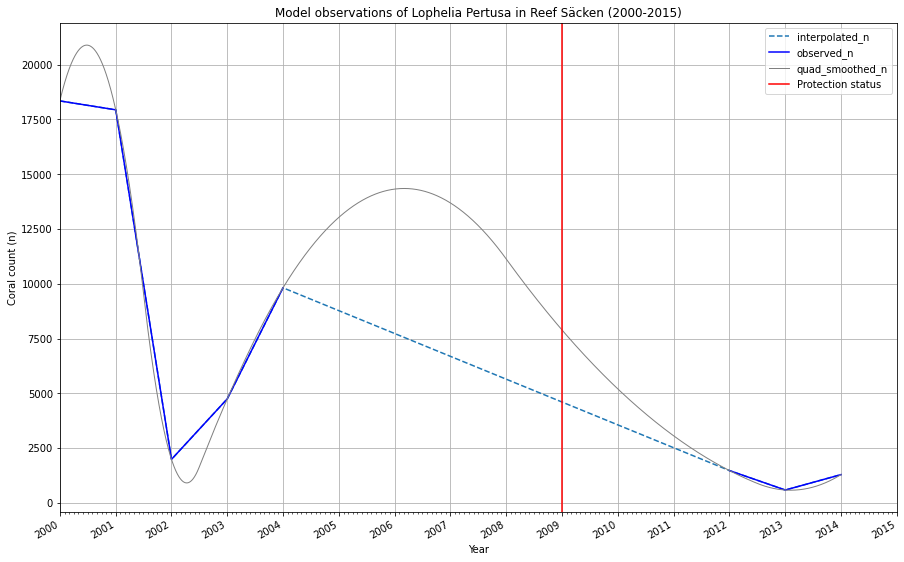

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

data = agg_df

fig, ax = plt.subplots(figsize=(15,10))
s1 = ax.plot('ym', 'n', data=data, linestyle='--', label='interpolated_n')
s2 = ax.plot('ym', 'n', data=data[data.ym <= '2004-12-31'], c='blue', label='observed_n')
s3 = ax.plot('ym', 'n', data=data[data.ym >= '2009-12-31'], c='blue', label='observed_n')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years.
datemin = np.datetime64(data['ym'][0], 'Y')
datemax = np.datetime64(data['ym'].iloc[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)


from scipy.interpolate import interp1d

x = convert_dates_to_days(data['ym'], start_date='2000-01-01')
f = interp1d(convert_dates_to_days(data['ym'], start_date='2000-01-01'),
             data['n'].values, kind='quadratic')


all_dates = pd.Series(pd.date_range('2000-01-01', '2014-01-01'))
x_all = convert_dates_to_days(all_dates, start_date='2000-01-01')
ax.plot(all_dates, f(x_all), '-', linewidth=1, c='gray', label='quad_smoothed_n')

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.axvline(x='2009', c='red', label='Protection status')
ax.legend()
plt.ylabel('Coral count (n)')
plt.xlabel('Year')

# Remove duplicate labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)

plt.legend(newHandles, newLabels)
plt.title('Model observations of Lophelia Pertusa in Reef Säcken (2000-2015)')
plt.show()

#### END OF NOTEBOOK